
# Preprocessing 
### This Notebook takes an image and the output is the binarized Image with horizontal staff lines
### It takes care of the enhancement of the image and choosing apropriate threshold


In [5]:
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle
from collections import Counter
import skimage.filters as fr
import skimage as sk
import cv2, time
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def binraization(img,n=64,t=30):

    outputimg = np.zeros(img.shape)
    intimg = np.zeros(img.shape)
    h = img.shape[1]
    w = img.shape[0]
    s= max(w,h)//n
    count = s**2
    intimg = np.cumsum(img ,axis =1)
    intimg = np.cumsum(intimg ,axis =0)
    a = np.roll(intimg,-s//2,axis =0)
    a = np.roll(a,-s//2,axis =1)
#     a[:,-s//2:]=0
#     a[-s//2:,:]=0
    b = np.roll(intimg,s//2+1,axis =0)
    b = np.roll(b,-s//2,axis =1)
    b[0:s//2+1,:]=0
#     b[:,-s//2:]=0
    
    c = np.roll(intimg,s//2+1,axis =1)
    c = np.roll(c,-s//2,axis =0)
    c[:,0:s//2+1]=0
#     c[-s//2:,:]=0
    
    d = np.roll(intimg,s//2+1,axis =0)
    d = np.roll(d,s//2+1,axis =1)
    d[0:s//2+1,:]=0
    d[:,0:s//2+1]=0

    sum = (a-b-c+d)*(100-t)/100
    outputimg = (img>sum/count)*255
    return outputimg

In [1]:
def getRefLengths(img):
    cols = img.shape[1]
    rows = img.shape[0]
    hist = np.zeros((rows,rows), dtype=np.uint32)
    
    for i in range(0, cols):
        a = img[:,i]
        starts = np.array((a[:-1] == 1) & (a[1:] == 0))
        starts_ix = np.where(starts)[0] + 2
        ends = np.array((a[:-1] == 0) & (a[1:] == 1))
        ends_ix = np.where(ends)[0] + 2
        s1 = starts_ix.size
        s2 = ends_ix.size
        if s2 > s1:
            starts_ix = np.pad(starts_ix,(s2-s1,0), mode='constant', constant_values=(1))
        elif s1 > s2:
            ends_ix = np.pad(ends_ix,(0,s1-s2), mode='constant', constant_values=(a.size + 1))
        elif s1 > 0 and s2 > 0 and starts_ix[0] > ends_ix[0]:
            starts_ix = np.pad(starts_ix,(1,0), mode='constant', constant_values=(1))
            ends_ix = np.pad(ends_ix,(0,1), mode='constant', constant_values=(a.size + 1))
            
        l0 = ends_ix - starts_ix
        starts_ix1 = np.pad(starts_ix[1:],(0,1), mode='constant', constant_values=(a.size + 1)) 
        l1 = starts_ix1 - (starts_ix + l0)
        for i in range(s1):
            hist[l0[i], l1[i]] += 1
       
    hist[:,0] = 0
    mx = np.max(hist)
    ind = np.where(hist == mx)
    return ind[0][0], ind[1][0]
  

In [6]:
def deleteLines(binary,w):
    theta = np.arange(-math.pi,math.pi,0.01)
    max_R = math.sqrt(binary.shape[0]**2 +  binary.shape[1]**2)
    vote_mat = np.zeros((int(theta.size),int(round(max_R))))
    for row in range(binary.shape[0]):
        for col in range(binary.shape[1]):
             if binary[row,col]==1:
                for i in range(theta.size):
                    R = math.cos(theta[i]) * col + math.sin(theta[i]) * row
                    if  R < int(round(max_R)) and R >= 0:
                        vote_mat[i,int(R)]+=1
    for j in range(vote_mat.shape[0]):
        for k in range(vote_mat.shape[1]):
            if vote_mat[j,k] > 100:
                thval = theta[j]
                rval = k
                for i in range(binary.shape[1]):
                    x1 = i
                    y1 = int(round((rval - math.cos(thval)*x1)/ math.sin(thval)))
                    if not binary[y1-w:y1,x1].all() and not binary[y1:y1+w,x1].all():
                        binary[y1,x1] = 0
    show_images([binary],['line removed'])
    return binary

In [7]:
paths = ['../../ex1.png', '../../ex2.png', '../../ex3.png', '../../ex4.png', '../../ex5.png']
for i in paths:
# i = '../../ex4.png'
    img = sk.img_as_ubyte(rgb2gray(io.imread(i)))
    imgb = binraization(img)
    img = getStaffLines(imgb)
    show_images([img])

#     thr = fr.threshold_otsu(img)
#     binary = np.where(img>thr, 1, 0)
#     lines_rv = deleteLines(binary,3)
#     staffHeight, spaceHeight = getRefLengths(binary)


staff height = 0 space Height = 0


NameError: name 'getCandidateStaffs' is not defined

In [ ]:
img = rgb2gray(io.imread("../Image-Processing/ex2.png"))

In [ ]:
show_images([img,binraization(img)],["orginal","binraized"])
io.imsave('bin.png', binraization(img))

In [ ]:
def getCandidateStaffs(binaryImg, staffHeight):
    filteredImg = np.copy(binaryImg)
    candidates = [] # Contains list of candidate staffs (row, begin, height)
    cols = filteredImg.shape[1]
    rows = filteredImg.shape[0]
    cur = 0
    upperLimitHeight = staffHeight+2
    lowerLimitHeight = abs(staffHeight-2)
    flag = False
    for i in range(cols):
        for j in range(rows):
            if filteredImg[j,i] == 0 and flag == False:
                beg = j
                flag = True
            elif filteredImg[j,i] == 1 and flag == True:
                flag = False
                if j-beg > upperLimitHeight or j-beg < lowerLimitHeight:
                    filteredImg[beg:j, i] = 1
                else:
                    candidates.append((i, beg, j-beg))
    return filteredImg, candidates

In [ ]:
def RemoveThinStaffs(v, filteredImg, staffHeight):
    cols = filteredImg.shape[1]
    rows = filteredImg.shape[0]
    candidates = v.copy()
    img = np.copy(filteredImg)
    eliminated = []
    for i in candidates:
        col, begin, length = i
        maxWidthLeft = 0
        maxWidthRight = 0
        wLeft = 0
        wRight = 0
        while col+wLeft+1 < cols and begin < i[1]+length:
#             print('testing filteredImg[',begin, col+wLeft+1)
            if filteredImg[begin, col+wLeft+1] == 0:
                wLeft += 1
            else:
                begin += 1
                maxWidthLeft = max(maxWidthLeft, wLeft)
                wLeft = 0
        maxWidthLeft = max(maxWidthLeft, wLeft)
        begin = i[1]
        while col-wRight-1 >= 0 and begin < i[1]+length:
#             print('testing filteredImg[',begin, col-wRight-1)
            if filteredImg[begin, col-wRight-1] == 0:
                wRight += 1
#                 print('zero')
            else:
#                 print('one')
                begin += 1
                maxWidthRight = max(maxWidthRight, wRight)
                wRight = 0
        maxWidthRight = max(maxWidthRight, wRight)
                
        width = maxWidthRight + maxWidthLeft +1
        if(width < 2*staffHeight):
            img[i[1]:i[1]+i[2], i[0]] = 1
            v.remove(i)
            eliminated.append(i)
    return img, v, eliminated

In [ ]:
def removeLonelyStaffs(v, filteredImg, staffHeight, spaceHeight, eliminated):
    verConnected = False
    horConnected = False
    c = v.copy()
    img = np.copy(filteredImg)
    cols = filteredImg.shape[1]
    rows = filteredImg.shape[0]
    staffs = np.ones(img.shape)

    for i in c:
        verConnected = False
        horConnected = False
        
        col, begin, length = i
        
        if col-1>=0 and np.any(filteredImg[begin:begin+length , col-1] == 0):
            horConnected = True
        if col+1<cols and np.any(filteredImg[begin:begin+length ,col+1] == 0):
            horConnected = True
            
        start = max(begin-(spaceHeight+staffHeight), 0)
        end = min(rows, begin+length+spaceHeight+staffHeight-1)
        if np.any(filteredImg[start:begin, col] == 0) or np.any(filteredImg[begin+length:end, col] == 0):
            verConnected = True
            
        if not (verConnected and horConnected):
            img[i[1]:i[1]+i[2], i[0]] = 1
            v.remove(i)
            eliminated.append(i)
    for i in v:
        staffs[i[1]:i[1]+i[2],i[0]] = 0
    return staffs, v, eliminated

In [ ]:
def addFalseNegatives(v, filteredImg, staffHeight, spaceHeight, eliminated):
    verConnected = False
    horConnected = False
    c = v.copy()
    eliminated.copy()
    img = np.copy(filteredImg)
    cols = filteredImg.shape[1]
    rows = filteredImg.shape[0]
    
    for i in eliminated:
        verConnected = False
        horConnected = False
        
        col, begin, length = i
        
        if col-1>=0 and np.any(filteredImg[begin:begin+length , col-1]):
            horConnected = True
        if col+1<cols and np.any(filteredImg[begin:begin+length ,col+1]):
            horConnected = True
        start = max(begin-(spaceHeight+staffHeight), 0)
        end = min(rows, begin+length+spaceHeight+staffHeight)
        if np.any(filteredImg[start:begin, col]) or np.any(filteredImg[begin+length:end, col]):
            verConnected = True
            
        if verConnected and horConnected:
            img[i[1]:i[1]+i[2], i[0]] = 0
            v.append(i)
            
    return img, v

In [ ]:
def getStaffLines(binary):
    staffHeight, spaceHeight = getRefLengths(binary)
    print('staff height =', staffHeight, 'space Height =', spaceHeight)    
    filteredImg, candidates = getCandidateStaffs(binary, staffHeight)
    filteredImg1, candidates, eliminated = RemoveThinStaffs(candidates, filteredImg, staffHeight)
    filteredImg2, candidates, eliminated = removeLonelyStaffs(candidates, binary, staffHeight, spaceHeight, eliminated)
    filteredImg3, candidates = addFalseNegatives(candidates, filteredImg2, staffHeight, staffHeight, eliminated)
    return filteredImg3

In [1]:
def getPts(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    rect[0,0] -= 20
    rect[0,1] -= 20
    
    rect[1,0] += 20
    rect[1,1] -= 20
    
    rect[2,0] += 20
    rect[2,1] += 20
    
    rect[3,0] -= 20
    rect[3,1] += 20
    
    # return the ordered coordinates
    return rect

In [10]:
def four_point_transform(image, rect):
    # obtain a consistent order of the points and unpack them
    # individually
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

In [14]:
def getAreaOfInterestPrivate(originalImage):
    img = cv2.GaussianBlur(originalImage,(3,3),1)
    edges = cv2.Canny(img, 30, 200)
    edges = np.pad(edges, 100, constant_values=0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 10))
    dilate = cv2.dilate(edges, kernel, iterations=5)
    contours, hierarchy = cv2.findContours(dilate.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    largestContour = contours[0]
    temp = np.zeros((largestContour.shape[0],2), dtype=largestContour.dtype)
    for i in range(largestContour.shape[0]):
        temp[i] = largestContour[i,0]
    
    
    
    firstRow = originalImage[0,:]
    lastRow = originalImage[originalImage.shape[0]-1,:]
    firstColumn = originalImage[:,0]
    lastColumn = originalImage[:,originalImage.shape[1]-1]
    
    t = np.mean(firstRow)
    firstRow[firstRow<t] = t
    t = np.mean(lastRow)
    lastRow[lastRow<t] = t
    t = np.mean(firstColumn)
    firstColumn[firstColumn<t] = t
    t = np.mean(lastColumn)
    lastColumn[lastColumn<t] = t
    
    originalImage = np.pad(originalImage, 100, mode="edge")
    warped = four_point_transform(originalImage, getPts(temp))
    return warped

In [19]:
def getAreaOfInterest(img):
    return getAreaOfInterestPrivate(getAreaOfInterestPrivate(getAreaOfInterestPrivate(img)))

time: 0.029834985733032227 seconds


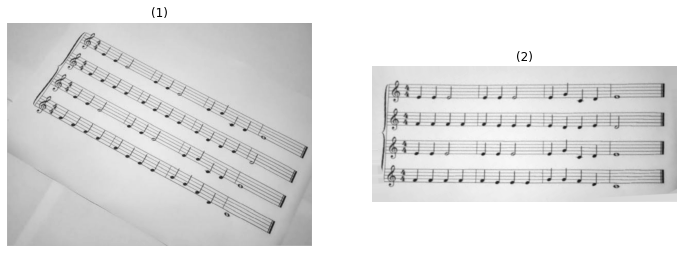

---------------------------------------------------------
time: 0.020874500274658203 seconds


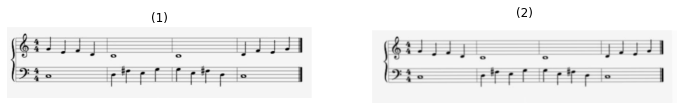

---------------------------------------------------------
time: 0.029232025146484375 seconds


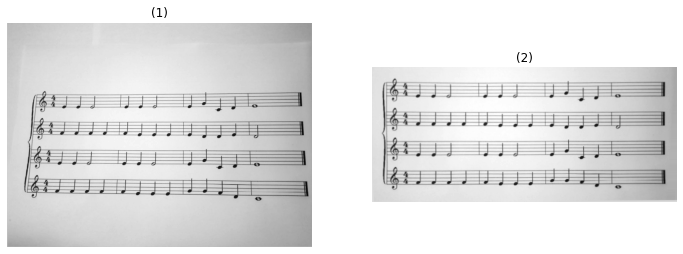

---------------------------------------------------------
time: 0.07935214042663574 seconds


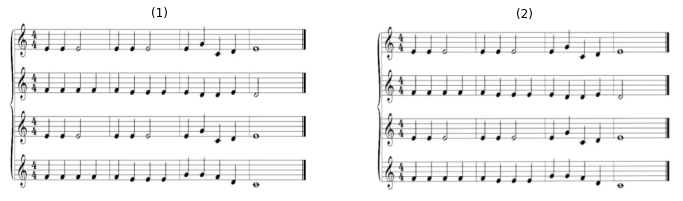

---------------------------------------------------------
time: 0.02385687828063965 seconds


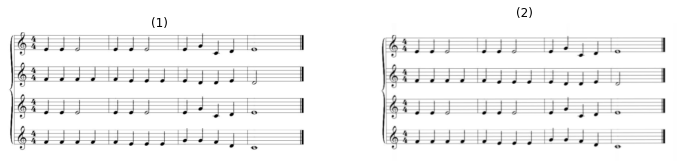

---------------------------------------------------------
time: 0.02711343765258789 seconds


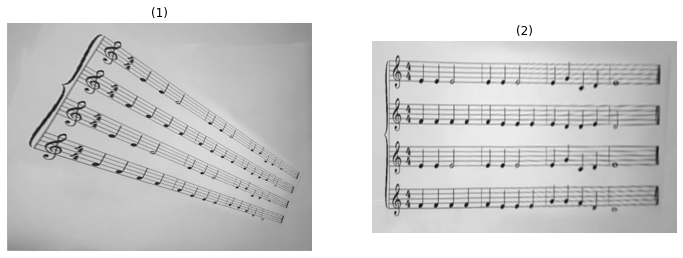

---------------------------------------------------------
time: 0.02321004867553711 seconds


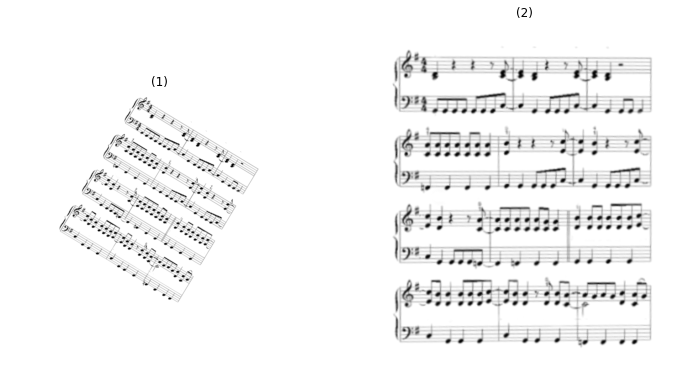

---------------------------------------------------------
time: 0.023816585540771484 seconds


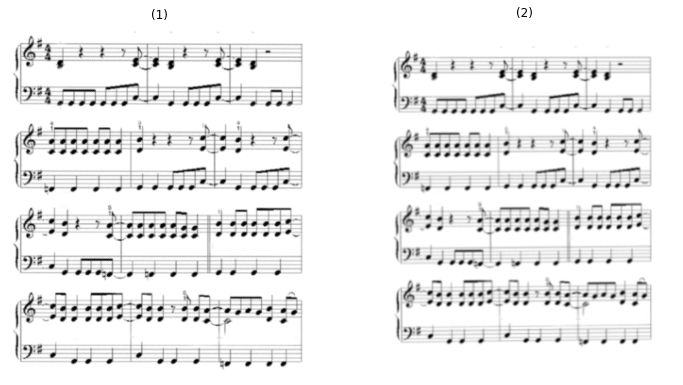

---------------------------------------------------------
time: 0.03933978080749512 seconds


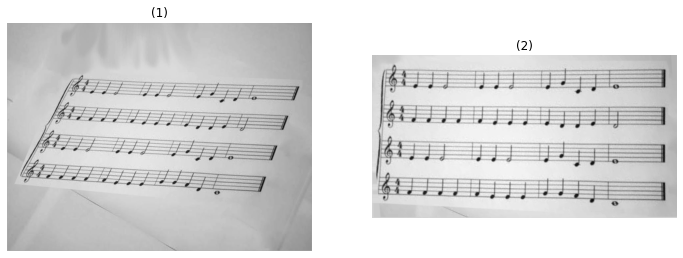

---------------------------------------------------------
time: 0.014521598815917969 seconds


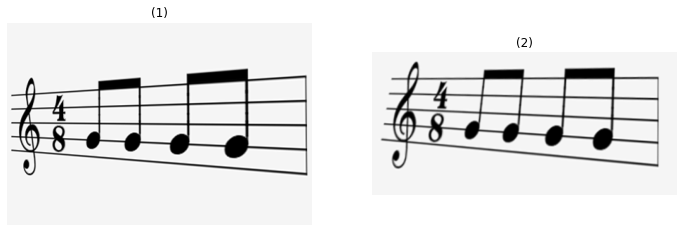

---------------------------------------------------------
time: 0.015994787216186523 seconds


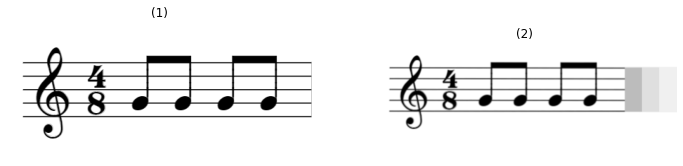

---------------------------------------------------------
time: 0.031914472579956055 seconds


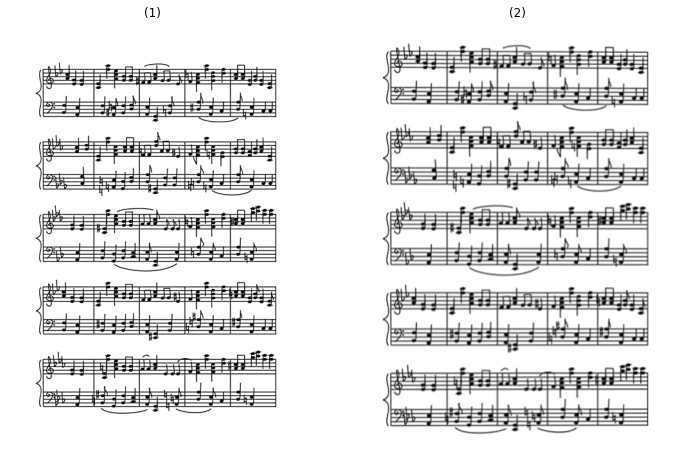

---------------------------------------------------------
time: 0.02640557289123535 seconds


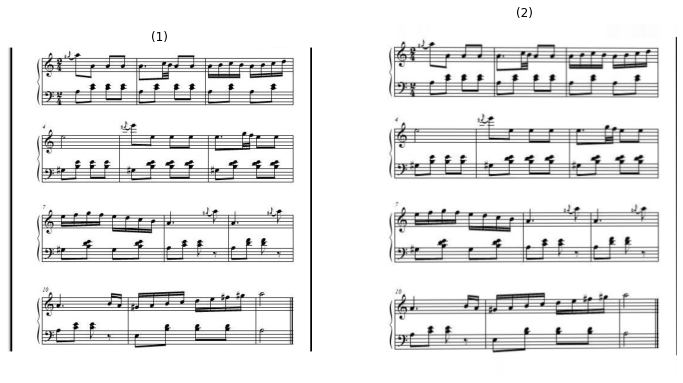

---------------------------------------------------------


In [20]:
paths = ['ex1.png','ex2.png', 'ex3.png', 'ex4.png', 'ex5.png', 'ex6.png',
         'ex7.png', 'ex8.png', 'ex9.jpg', 'ex10.png', 'ex11.png','ex12.jpg','ex13.jpg']

for i in paths:
    img = cv2.imread(i,0)
    start_time = time.time()
    area = getAreaOfInterest(img)
    print("time: %s seconds" % (time.time() - start_time))
    show_images([img, area])
    print("---------------------------------------------------------")
    